# Clustering

See our notes on [unsupervised learning](https://jennselby.github.io/MachineLearningCourseNotes/#unsupervised-learning), [K-means](https://jennselby.github.io/MachineLearningCourseNotes/#k-means-clustering), [DBSCAN](https://jennselby.github.io/MachineLearningCourseNotes/#dbscan-clustering), and [clustering validation](https://jennselby.github.io/MachineLearningCourseNotes/#clustering-validation).

For documentation of various clustering methods in scikit-learn, see http://scikit-learn.org/stable/modules/clustering.html

This code was based on the example at http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
which has the following comments:

Code source: Gaël Varoquaux<br/>
Modified for documentation by Jaques Grobler<br/>
License: BSD 3 clause
## Instructions
0. If you haven't already, follow [the setup instructions here](https://jennselby.github.io/MachineLearningCourseNotes/#setting-up-python3) to get all necessary software installed.
1. Read through the code in the following sections:
    * [Iris Dataset](#Iris-Dataset)
    * [Visualization](#Visualization)
    * [Training and Visualization](#Training-and-Visualization)
2. Complete the three-part [Exercise](#Exercise)

In [3]:
%matplotlib inline
import numpy
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics

import pandas

import random
import math

import copy

## Iris Dataset

Before you go on, if you haven't used the iris dataset in a previous assignment, make sure you understand it. Modify the cell below to examine different parts of the dataset that are contained in the iris dictionary object.

What are the features? What are we trying to classify?

In [4]:
iris = datasets.load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
iris_df = pandas.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Visualization Setup

In [6]:
# We can only plot 3 of the 4 iris features, since we only see in 3D.
# These are the ones the example code picked
X_FEATURE = 'petal width (cm)' 
Y_FEATURE = 'sepal length (cm)' 
Z_FEATURE = 'petal length (cm)'

# set some bounds for the figures that will display the plots of clusterings with various
# hyperparameter settings
# this allows for NUM_COLS * NUM_ROWS plots in the figure
NUM_COLS = 4
NUM_ROWS = 6
FIG_WIDTH = 4 * NUM_COLS
FIG_HEIGHT = 3 * NUM_ROWS

def add_plot(figure, subplot_num, subplot_name, data, labels):
    '''Create a new subplot in the figure.'''

    # create a new subplot
    axis = figure.add_subplot(NUM_ROWS, NUM_COLS, subplot_num, projection='3d',
                              elev=30, azim=134)

    # Plot three of the four features on the graph, and set the color according to the labels
    axis.scatter(data[X_FEATURE], data[Y_FEATURE], data[Z_FEATURE], c=labels)

    # get rid of the tick numbers. Otherwise, they all overlap and it looks horrible
    for axis_obj in [axis.w_xaxis, axis.w_yaxis, axis.w_zaxis]:
        axis_obj.set_ticklabels([])

    # label the subplot
    axis.title.set_text(subplot_name)

## Visualization

This is the correct labeling, based on the targets.

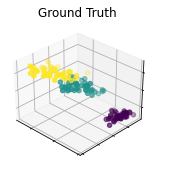

In [140]:
# start a new figure to hold all of the subplots
truth_figure = matplotlib.pyplot.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Plot the ground truth
add_plot(truth_figure, 1, "Ground Truth", iris_df, iris.target)

## Training and Visualization

Now let's see how k-means clusters the iris dataset, with various different numbers of clusters

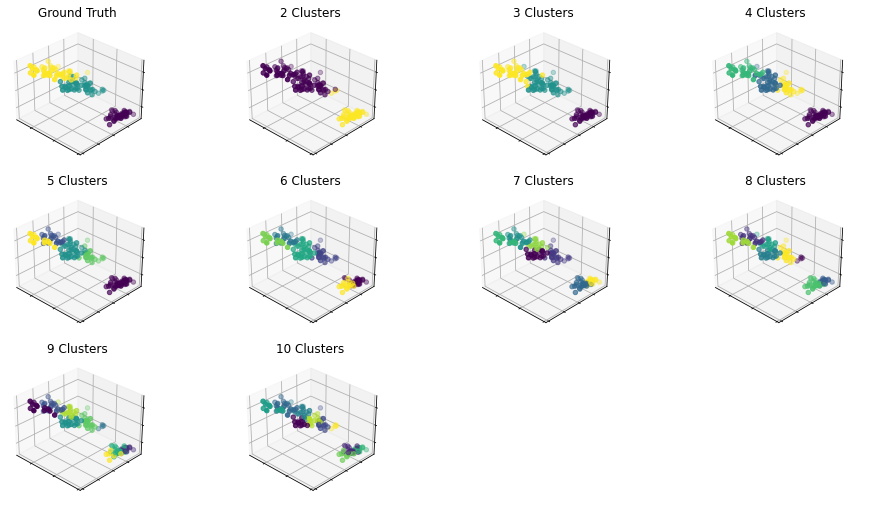

In [141]:
MAX_CLUSTERS = 10
# start a new figure to hold all of the subplots
kmeans_figure = matplotlib.pyplot.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Plot the ground truth
add_plot(kmeans_figure, 1, "Ground Truth", iris_df, iris.target)

plot_num = 2
for num_clusters in range(2, MAX_CLUSTERS + 1):
    # train the model
    model = KMeans(n_clusters=num_clusters)
    model.fit(iris_df)
    
    # get the predictions of which cluster each input is in
    labels = model.labels_

    # plot this clustering
    title = '{} Clusters'.format(num_clusters) 
    add_plot(kmeans_figure, plot_num, title, iris_df, labels.astype(numpy.float))
    plot_num += 1

# Implementing K-means From Scratch

In [63]:
def closest_centroid(point, centroid_list):
    distances = []
    for center in centroid_list:  # comparing distances from point to each centroid
        dist = math.hypot(*(x[0]-x[1] for x in zip(point, center)))  # https://stackoverflow.com/questions/5228383/how-do-i-find-the-distance-between-two-points
        distances.append(dist)
    val, idx = min((val, idx) for (idx, val) in enumerate(distances))  # https://stackoverflow.com/questions/13300962/python-find-index-of-minimum-item-in-list-of-floats
    return idx  # returns index of centroid closest to point

In [92]:
def average_point(point_list):
    return [sum(x)/len(x) for x in zip(*point_list)]  # https://stackoverflow.com/questions/55153446/getting-the-average-of-a-list-of-coordinates-in-python

In [54]:
def label_points(point_list, centroid_list):  # generates list of the corresponding centroid index for each point
    labels = []
    for point in point_list:
        labels.append(closest_centroid(point, centroid_list))
    return labels

In [55]:
def random_coords(point_list, num_coords):
    min_coords = [min(x) for x in zip(*point_list)]  # finds minimum for each column in point_list
    max_coords = [max(x) for x in zip(*point_list)]
    coords = []
    for i in range(num_coords):
        coords.append(list(random.uniform(x[0], x[1]) for x in zip(min_coords, max_coords)))  # loops through mins and maxs of columns
    return coords

In [56]:
def points_by_label(point_list, label_list, label):  # equivalent point_list[label_list == label] if they were pandas dfs
    points = []
    for i in range(len(point_list)):
        if label_list[i] == label:
            points.append(point_list[i])
    return points

In [332]:
def kmeans_clusters(point_list, num_clusters, num_iters):
    centroid_list = random_coords(point_list, num_clusters)
    for rep in range(num_iters):
        print(centroid_list)
        labels = label_points(point_list, centroid_list)  # assign centroid to each point
        for c in range(len(centroid_list)):  # change each centroid to average of points assigned to it
            centroid_list[c] = average_point(points_by_label(point_list, labels, c))
    return centroid_list, labels

# Implementing DBscan From Scratch

In [7]:
def within_radius(coord, center, radius):
    return radius >= math.hypot(*(x[0]-x[1] for x in zip(coord, center)))

In [8]:
def points_in_radius(point_list, center, radius, queue=[]):
    point_indices = []
    for j in range(len(point_list)):
        if not j in queue:
            if within_radius(point_list[j], point_list[center], radius):
                point_indices.append(j)
    return point_indices

In [9]:
def determine_cluster(point_list, center, radius, queue=[]):
    queue = copy.deepcopy(queue)
    queue.append(center)
    near_points = points_in_radius(point_list, center, radius, queue)
    for idx in near_points:
        queue = determine_cluster(point_list, idx, radius, queue)
    return queue

In [10]:
def dbscan_clusters(point_list, radius, min_neighbor):
    cluster_counter = 2  # 0 means untested, 1 means noise, the rest are clusters
    labels = [0 for x in range(len(point_list))]
    for i in range(len(point_list)):
        if labels[i] == 0:
            if len(points_in_radius(point_list, i, radius, [i])) >= min_neighbor:
                new_cluster = determine_cluster(point_list, i, radius)
                for idx in new_cluster:
                    labels[idx] = cluster_counter
                cluster_counter += 1
            else:
                labels[i] = 1
    return labels

# For everything I did already for the clustering assignment check out the ClusteringIris doc in this folder

# Final Project
## "I also like your plans for future exploration, including standardizing the data for DBSCAN, working on a hierarchical clustering implementation, and implementing a balanced K-means algoirthm. If you’re interested in coming back to this, this would make a fine final exploration project!"

# Implementing Hierarchical Clustering From Scratch

In [213]:
def find_distances(point_list):
    distance_list = []
    for idx in range(len(point_list)):
        current_point = point_list[idx]
        distance_list.extend([math.hypot(*(x[0]-x[1] for x in zip(current_point, new_point))) for new_point in point_list[idx+1:]])
    #print(distance_list)
    return distance_list

In [214]:
def sort_distances(distance_list):
    indexed_distances = dict(zip(range(len(distance_list)), distance_list))  # https://stackoverflow.com/questions/716477/join-list-of-lists-in-python
    #print(indexed_distances)
    sorted_indices = [i[0] for i in sorted(indexed_distances.items(), key=lambda x: x[1])]  # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    return sorted_indices

In [215]:
def index_to_points(idx, num_points):
    for num in range(num_points-1, -1, -1):
        if idx < num:
            first_point = num_points - num - 1
            break
        idx -= num
    second_point = first_point+idx+1
    return first_point,second_point

In [222]:
def hierarchical_clusters(point_list):
    distance_list = find_distances(point_list)
    sorted_indices = sort_distances(distance_list)
    #print(sorted_indices)
    
    # I didn't feel like learning a tree library so...
    taxonomy = {'contains': [], 'dist':0, 'children': []}
    for idx in sorted_indices:
        first, second = index_to_points(idx, len(point_list))
        if first in taxonomy['contains'] and second in taxonomy['contains']:
            if len(taxonomy['contains']) == len(point_list):
                for child_idx in range(len(taxonomy['children'])):
                    if first in taxonomy['children'][child_idx]['contains']:
                        initial_found = child_idx
                for child_idx in range(len(taxonomy['children'])):
                    if second in taxonomy['children'][child_idx]['contains']:
                        taxonomy['children'][child_idx] = {'contains': taxonomy['children'][initial_found]['contains']+taxonomy['children'][child_idx]['contains'], 'dist': distance_list[idx], 'children': [taxonomy['children'][initial_found], taxonomy['children'][child_idx]]}
                del taxonomy['children'][initial_found]
                break
            else:
                continue
        elif first in taxonomy['contains'] or second in taxonomy['contains']:
            for child_idx in range(len(taxonomy['children'])):
                if first in taxonomy['children'][child_idx]['contains']:
                    taxonomy['children'][child_idx] = {'contains': taxonomy['children'][child_idx]['contains']+[second], 'dist': distance_list[idx], 'children': [taxonomy['children'][child_idx], second]}
                    taxonomy['contains'].append(second)
                elif second in taxonomy['children'][child_idx]['contains']:
                    taxonomy['children'][child_idx] = {'contains': taxonomy['children'][child_idx]['contains']+[first], 'dist': distance_list[idx], 'children': [taxonomy['children'][child_idx], first]}
                    taxonomy['contains'].append(first)
        else:
            taxonomy['children'].append({'contains': [first, second], 'dist': distance_list[idx], 'children': [first, second]})
            taxonomy['contains'].extend([first, second])
        #print(taxonomy)
    return taxonomy
    
#     {
#         "contains": [indices],
#         "children": [
#             {"contains": [subindices], "children": []},
#             {"contains": [subindices prime], "children": []}
#         ]
#     }
    

In [8]:
list(range(10-1, -1, -1))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [12]:
index_to_points(2, 4)

(0, 3)

In [ ]:
[0, 1, 2]
[3, 4]
[5]
[]

In [3]:
test_list = [[1,1],[1,2],[1,3],[3,3],[3,4],[-1,0],[-2,0],[-3,3]]

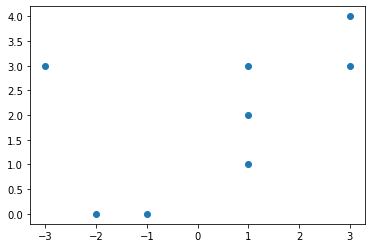

In [15]:
matplotlib.pyplot.scatter([x[0] for x in test_list], [x[1] for x in test_list])

In [70]:
hierarchical_clusters(test_list)

[1.0, 2.0, 2.8284271247461903, 3.6055512754639896, 2.23606797749979, 3.1622776601683795, 4.47213595499958, 1.0, 2.23606797749979, 2.8284271247461903, 2.8284271247461903, 3.6055512754639896, 4.123105625617661, 2.0, 2.23606797749979, 3.6055512754639896, 4.242640687119286, 4.0, 1.0, 5.0, 5.8309518948453, 6.0, 5.656854249492381, 6.4031242374328485, 6.0827625302982185, 1.0, 3.6055512754639896, 3.1622776601683795]
{0: 1.0, 1: 2.0, 2: 2.8284271247461903, 3: 3.6055512754639896, 4: 2.23606797749979, 5: 3.1622776601683795, 6: 4.47213595499958, 7: 1.0, 8: 2.23606797749979, 9: 2.8284271247461903, 10: 2.8284271247461903, 11: 3.6055512754639896, 12: 4.123105625617661, 13: 2.0, 14: 2.23606797749979, 15: 3.6055512754639896, 16: 4.242640687119286, 17: 4.0, 18: 1.0, 19: 5.0, 20: 5.8309518948453, 21: 6.0, 22: 5.656854249492381, 23: 6.4031242374328485, 24: 6.0827625302982185, 25: 1.0, 26: 3.6055512754639896, 27: 3.1622776601683795}
[0, 7, 18, 25, 1, 13, 4, 8, 14, 2, 9, 10, 5, 27, 3, 11, 15, 26, 17, 12, 16

{'contains': [0, 1, 2, 3, 4, 5, 6, 7],
 'dist': 0,
 'children': [{'contains': [0, 1, 2, 3, 4],
   'dist': 3.6055512754639896,
   'children': [{'contains': [0, 1, 2],
     'dist': 1.0,
     'children': [{'contains': [0, 1], 'dist': 1.0, 'children': [0, 1]}, 2]},
    {'contains': [3, 4], 'dist': 1.0, 'children': [3, 4]}]},
  {'contains': [5, 6, 7],
   'dist': 3.1622776601683795,
   'children': [{'contains': [5, 6], 'dist': 1.0, 'children': [5, 6]}, 7]}]}

Now that's beautiful

In [188]:
def split_by_number(taxonomy, num_clusters, num_points):
    sub_clusters = copy.deepcopy(taxonomy['children'])
    while len(sub_clusters) != num_clusters:
        max_dist = 0
        max_dist_child_idx = 0
        for child_idx in range(len(sub_clusters)):  # finding the subcluster where the distance is between the largest
            if type(sub_clusters[child_idx]) is int:
                continue
            if sub_clusters[child_idx]['dist'] > max_dist:
                max_dist = sub_clusters[child_idx]['dist']
                max_dist_child_idx = child_idx
        # each node is only the parent of 2 subclusters so each of these loops adds one subcluster
        sub_clusters.extend(sub_clusters[max_dist_child_idx]['children'])
        del sub_clusters[max_dist_child_idx]
    point_labels = list(range(num_points))
    for child_idx in range(len(sub_clusters)):
        if type(sub_clusters[child_idx]) is int:
            point_labels[sub_clusters[child_idx]] = child_idx
        else:
            for x in sub_clusters[child_idx]['contains']:
                point_labels[x] = child_idx
    return point_labels

In [75]:
test_clusters = hierarchical_clusters(test_list)
print(test_clusters)
test_labels = split_by_number(test_clusters, 3, len(test_list))
test_labels

[1.0, 2.0, 2.8284271247461903, 3.6055512754639896, 2.23606797749979, 3.1622776601683795, 4.47213595499958, 1.0, 2.23606797749979, 2.8284271247461903, 2.8284271247461903, 3.6055512754639896, 4.123105625617661, 2.0, 2.23606797749979, 3.6055512754639896, 4.242640687119286, 4.0, 1.0, 5.0, 5.8309518948453, 6.0, 5.656854249492381, 6.4031242374328485, 6.0827625302982185, 1.0, 3.6055512754639896, 3.1622776601683795]
{0: 1.0, 1: 2.0, 2: 2.8284271247461903, 3: 3.6055512754639896, 4: 2.23606797749979, 5: 3.1622776601683795, 6: 4.47213595499958, 7: 1.0, 8: 2.23606797749979, 9: 2.8284271247461903, 10: 2.8284271247461903, 11: 3.6055512754639896, 12: 4.123105625617661, 13: 2.0, 14: 2.23606797749979, 15: 3.6055512754639896, 16: 4.242640687119286, 17: 4.0, 18: 1.0, 19: 5.0, 20: 5.8309518948453, 21: 6.0, 22: 5.656854249492381, 23: 6.4031242374328485, 24: 6.0827625302982185, 25: 1.0, 26: 3.6055512754639896, 27: 3.1622776601683795}
[0, 7, 18, 25, 1, 13, 4, 8, 14, 2, 9, 10, 5, 27, 3, 11, 15, 26, 17, 12, 16

[0, 0, 0, 0, 0, 1, 1, 2]

In [114]:
test_clusters = hierarchical_clusters(test_list)
test_labels = split_by_number(test_clusters, 3, len(test_list))
test_labels

[1.0, 2.0, 2.8284271247461903, 3.6055512754639896, 2.23606797749979, 3.1622776601683795, 4.47213595499958, 1.0, 2.23606797749979, 2.8284271247461903, 2.8284271247461903, 3.6055512754639896, 4.123105625617661, 2.0, 2.23606797749979, 3.6055512754639896, 4.242640687119286, 4.0, 1.0, 5.0, 5.8309518948453, 6.0, 5.656854249492381, 6.4031242374328485, 6.0827625302982185, 1.0, 3.6055512754639896, 3.1622776601683795]
{0: 1.0, 1: 2.0, 2: 2.8284271247461903, 3: 3.6055512754639896, 4: 2.23606797749979, 5: 3.1622776601683795, 6: 4.47213595499958, 7: 1.0, 8: 2.23606797749979, 9: 2.8284271247461903, 10: 2.8284271247461903, 11: 3.6055512754639896, 12: 4.123105625617661, 13: 2.0, 14: 2.23606797749979, 15: 3.6055512754639896, 16: 4.242640687119286, 17: 4.0, 18: 1.0, 19: 5.0, 20: 5.8309518948453, 21: 6.0, 22: 5.656854249492381, 23: 6.4031242374328485, 24: 6.0827625302982185, 25: 1.0, 26: 3.6055512754639896, 27: 3.1622776601683795}
[0, 7, 18, 25, 1, 13, 4, 8, 14, 2, 9, 10, 5, 27, 3, 11, 15, 26, 17, 12, 16

[1, 1, 1, 2, 2, 0, 0, 0]

In [115]:
split_by_number(test_clusters, 4, len(test_list))

[0, 0, 0, 1, 1, 2, 2, 3]

In [169]:
def test_hierarchical_clusters(point_list):  # looking to fix the issue where the super far point was in a cluster with the bottom left and not on it's own
    distance_list = find_distances(point_list)
    sorted_indices = sort_distances(distance_list)
    print(sorted_indices)
    
    # I didn't feel like learning a tree library so...
    taxonomy = {'contains': [], 'dist':0, 'children': []}
    for idx in sorted_indices:
        first, second = index_to_points(idx, len(point_list))
        print('idx time', first, second, distance_list[idx])
        if first in taxonomy['contains'] and second in taxonomy['contains']:  # all the issues come from this guy haha
            if len(taxonomy['contains']) == len(point_list):
                break
            print('in the big bad boy')
            if len(taxonomy['children'])>1:
                print('len time')
                for child_idx in range(len(taxonomy['children'])):
                    if first in taxonomy['children'][child_idx]['contains']:
                        initial_found = child_idx
                for child_idx in range(len(taxonomy['children'])):
                    if second in taxonomy['children'][child_idx]['contains'] and initial_found != child_idx:
                        print('in da second', initial_found, child_idx, taxonomy['children'][child_idx])
                        taxonomy['children'][child_idx] = {'contains': taxonomy['children'][initial_found]['contains']+taxonomy['children'][child_idx]['contains'], 'dist': distance_list[idx], 'children': [taxonomy['children'][initial_found], taxonomy['children'][child_idx]]}
                        print('after da ting', taxonomy['children'][child_idx], 'boutta get delet', taxonomy['children'][initial_found])
                        del taxonomy['children'][initial_found]
                        break
                #taxonomy['children'][initial_found]['contains'] = []
                #taxonomy['children'].pop(initial_found)
                #break
            #else:
            #    continue
        elif first in taxonomy['contains'] or second in taxonomy['contains']:
            for child_idx in range(len(taxonomy['children'])):
                if first in taxonomy['children'][child_idx]['contains']:
                    taxonomy['children'][child_idx] = {'contains': taxonomy['children'][child_idx]['contains']+[second], 'dist': distance_list[idx], 'children': [taxonomy['children'][child_idx], second]}
                    taxonomy['contains'].append(second)
                elif second in taxonomy['children'][child_idx]['contains']:
                    taxonomy['children'][child_idx] = {'contains': taxonomy['children'][child_idx]['contains']+[first], 'dist': distance_list[idx], 'children': [taxonomy['children'][child_idx], first]}
                    taxonomy['contains'].append(first)
        else:
            taxonomy['children'].append({'contains': [first, second], 'dist': distance_list[idx], 'children': [first, second]})
            taxonomy['contains'].extend([first, second])
        print(taxonomy)
#         if len(taxonomy['contains']) == len(point_list):
#             break
    return taxonomy
    
#     {
#         "contains": [indices],
#         "children": [
#             {"contains": [subindices], "children": []},
#             {"contains": [subindices prime], "children": []}
#         ]
#     }
    

In [170]:
test_clusters = test_hierarchical_clusters(test_list)
print(test_clusters)
test_labels = split_by_number(test_clusters, 2, len(test_list))
test_labels

[1.0, 2.0, 2.8284271247461903, 3.6055512754639896, 2.23606797749979, 3.1622776601683795, 4.47213595499958, 1.0, 2.23606797749979, 2.8284271247461903, 2.8284271247461903, 3.6055512754639896, 4.123105625617661, 2.0, 2.23606797749979, 3.6055512754639896, 4.242640687119286, 4.0, 1.0, 5.0, 5.8309518948453, 6.0, 5.656854249492381, 6.4031242374328485, 6.0827625302982185, 1.0, 3.6055512754639896, 3.1622776601683795]
{0: 1.0, 1: 2.0, 2: 2.8284271247461903, 3: 3.6055512754639896, 4: 2.23606797749979, 5: 3.1622776601683795, 6: 4.47213595499958, 7: 1.0, 8: 2.23606797749979, 9: 2.8284271247461903, 10: 2.8284271247461903, 11: 3.6055512754639896, 12: 4.123105625617661, 13: 2.0, 14: 2.23606797749979, 15: 3.6055512754639896, 16: 4.242640687119286, 17: 4.0, 18: 1.0, 19: 5.0, 20: 5.8309518948453, 21: 6.0, 22: 5.656854249492381, 23: 6.4031242374328485, 24: 6.0827625302982185, 25: 1.0, 26: 3.6055512754639896, 27: 3.1622776601683795}
[0, 7, 18, 25, 1, 13, 4, 8, 14, 2, 9, 10, 5, 27, 3, 11, 15, 26, 17, 12, 16

[0, 0, 0, 0, 0, 0, 0, 1]

In [173]:
test_clusters = test_hierarchical_clusters([[1,1], [1,2], [-1,0], [-3,0], [-5,5]])
print(test_clusters)
test_labels = split_by_number(test_clusters, 2, len(test_list))
test_labels

[1.0, 2.23606797749979, 4.123105625617661, 7.211102550927979, 2.8284271247461903, 4.47213595499958, 6.708203932499369, 2.0, 6.4031242374328485, 5.385164807134505]
{0: 1.0, 1: 2.23606797749979, 2: 4.123105625617661, 3: 7.211102550927979, 4: 2.8284271247461903, 5: 4.47213595499958, 6: 6.708203932499369, 7: 2.0, 8: 6.4031242374328485, 9: 5.385164807134505}
[0, 7, 1, 4, 2, 5, 9, 8, 6, 3]
idx time 0 1 1.0
{'contains': [0, 1], 'dist': 0, 'children': [{'contains': [0, 1], 'dist': 1.0, 'children': [0, 1]}]}
idx time 2 3 2.0
{'contains': [0, 1, 2, 3], 'dist': 0, 'children': [{'contains': [0, 1], 'dist': 1.0, 'children': [0, 1]}, {'contains': [2, 3], 'dist': 2.0, 'children': [2, 3]}]}
idx time 0 2 2.23606797749979
in the big bad boy
len time
in da second 0 1 {'contains': [2, 3], 'dist': 2.0, 'children': [2, 3]}
after da ting {'contains': [0, 1, 2, 3], 'dist': 2.23606797749979, 'children': [{'contains': [0, 1], 'dist': 1.0, 'children': [0, 1]}, {'contains': [2, 3], 'dist': 2.0, 'children': [2, 3]

[0, 0, 0, 0, 1, 5, 6, 7]

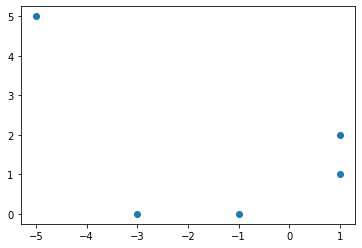

In [146]:
matplotlib.pyplot.scatter([x[0] for x in [[1,1], [1,2], [-1,0], [-3,0], [-5,5]]], [x[1] for x in [[1,1], [1,2], [-1,0], [-3,0], [-5,5]]])

In [217]:
def new_hierarchical_clusters(point_list):  # cleaned up test_hierarchical_cluster
    distance_list = find_distances(point_list)
    sorted_indices = sort_distances(distance_list)
    
    # I didn't feel like learning a tree library so...
    taxonomy = {'contains': [], 'dist':0, 'children': []}
    for idx in sorted_indices:
        first, second = index_to_points(idx, len(point_list))
        if first in taxonomy['contains'] and second in taxonomy['contains']:
            if len(taxonomy['contains']) == len(point_list):
                break
            if len(taxonomy['children'])>1:
                for child_idx in range(len(taxonomy['children'])):
                    if first in taxonomy['children'][child_idx]['contains']:
                        initial_found = child_idx
                for child_idx in range(len(taxonomy['children'])):
                    if second in taxonomy['children'][child_idx]['contains'] and initial_found != child_idx:
                        taxonomy['children'][child_idx] = {'contains': taxonomy['children'][initial_found]['contains']+taxonomy['children'][child_idx]['contains'], 'dist': distance_list[idx], 'children': [taxonomy['children'][initial_found], taxonomy['children'][child_idx]]}
                        del taxonomy['children'][initial_found]
                        break
        elif first in taxonomy['contains'] or second in taxonomy['contains']:
            for child_idx in range(len(taxonomy['children'])):
                if first in taxonomy['children'][child_idx]['contains']:
                    taxonomy['children'][child_idx] = {'contains': taxonomy['children'][child_idx]['contains']+[second], 'dist': distance_list[idx], 'children': [taxonomy['children'][child_idx], second]}
                    taxonomy['contains'].append(second)
                elif second in taxonomy['children'][child_idx]['contains']:
                    taxonomy['children'][child_idx] = {'contains': taxonomy['children'][child_idx]['contains']+[first], 'dist': distance_list[idx], 'children': [taxonomy['children'][child_idx], first]}
                    taxonomy['contains'].append(first)
        else:
            taxonomy['children'].append({'contains': [first, second], 'dist': distance_list[idx], 'children': [first, second]})
            taxonomy['contains'].extend([first, second])
    return taxonomy

In [193]:
test_clusters = new_hierarchical_clusters(test_list)
print(test_clusters)
test_labels = split_by_number(test_clusters, 4, len(test_list))
test_labels

[1.0, 2.0, 2.8284271247461903, 3.6055512754639896, 2.23606797749979, 3.1622776601683795, 4.47213595499958, 1.0, 2.23606797749979, 2.8284271247461903, 2.8284271247461903, 3.6055512754639896, 4.123105625617661, 2.0, 2.23606797749979, 3.6055512754639896, 4.242640687119286, 4.0, 1.0, 5.0, 5.8309518948453, 6.0, 5.656854249492381, 6.4031242374328485, 6.0827625302982185, 1.0, 3.6055512754639896, 3.1622776601683795]
{0: 1.0, 1: 2.0, 2: 2.8284271247461903, 3: 3.6055512754639896, 4: 2.23606797749979, 5: 3.1622776601683795, 6: 4.47213595499958, 7: 1.0, 8: 2.23606797749979, 9: 2.8284271247461903, 10: 2.8284271247461903, 11: 3.6055512754639896, 12: 4.123105625617661, 13: 2.0, 14: 2.23606797749979, 15: 3.6055512754639896, 16: 4.242640687119286, 17: 4.0, 18: 1.0, 19: 5.0, 20: 5.8309518948453, 21: 6.0, 22: 5.656854249492381, 23: 6.4031242374328485, 24: 6.0827625302982185, 25: 1.0, 26: 3.6055512754639896, 27: 3.1622776601683795}
[0, 7, 18, 25, 1, 13, 4, 8, 14, 2, 9, 10, 5, 27, 3, 11, 15, 26, 17, 12, 16

[2, 2, 2, 3, 3, 1, 1, 0]

Ok, that was way harder mentally and debugging wise than any other assignment I've done in ML.

## Testing on Iris Data

### Ground Truth 2D

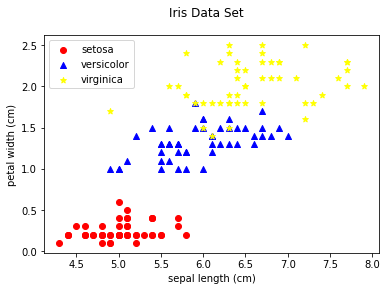

In [41]:
x1_feature = 0
x2_feature = 3

start_class_one = list(iris.target).index(1)
start_class_two = list(iris.target).index(2)

x1 = iris_inputs[:,0]
x2 = iris_inputs[:,1]

# create a figure and label it
fig = matplotlib.pyplot.figure()
fig.suptitle('Iris Data Set')
matplotlib.pyplot.xlabel(iris.feature_names[x1_feature])
matplotlib.pyplot.ylabel(iris.feature_names[x2_feature])

# put the input data on the graph, with different colors and shapes for each type
scatter_0 = matplotlib.pyplot.scatter(x1[:start_class_one], x2[:start_class_one],
                                      c="red", marker="o", label=iris.target_names[0])
scatter_1 = matplotlib.pyplot.scatter(x1[start_class_one:start_class_two], x2[start_class_one:start_class_two],
                                      c="blue", marker="^", label=iris.target_names[1])
scatter_2 = matplotlib.pyplot.scatter(x1[start_class_two:], x2[start_class_two:],
                                      c="yellow", marker="*", label=iris.target_names[2])

# add a legend to explain which points are which
matplotlib.pyplot.legend(handles=[scatter_0, scatter_1, scatter_2])

# show the graph
matplotlib.pyplot.show()

### Hierarchical 3 Clusters 2D

In [228]:
iris_inputs = iris.data[:,[0,3]]
iris_inputs_list = iris_inputs.tolist()
iris_taxonomy = new_hierarchical_clusters(iris_inputs_list)
iris_labels = split_by_number(iris_taxonomy, 3, len(iris_inputs_list))

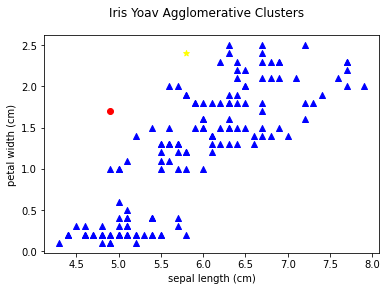

In [229]:
iris_labels = numpy.array(iris_labels)

fig = matplotlib.pyplot.figure()
fig.suptitle('Iris Yoav Agglomerative Clusters')
matplotlib.pyplot.xlabel(iris.feature_names[x1_feature])
matplotlib.pyplot.ylabel(iris.feature_names[x2_feature])

scatter_0 = matplotlib.pyplot.scatter(x1[iris_labels==0], x2[iris_labels==0],
                                      c="red", marker="o", label=iris.target_names[0])
scatter_1 = matplotlib.pyplot.scatter(x1[iris_labels==1], x2[iris_labels==1],
                                      c="blue", marker="^", label=iris.target_names[1])
scatter_2 = matplotlib.pyplot.scatter(x1[iris_labels==2], x2[iris_labels==2],
                                      c="yellow", marker="*", label=iris.target_names[2])
scatter_3 = matplotlib.pyplot.scatter(x1[iris_labels==3], x2[iris_labels==3],
                                      c="green", marker="o")

#matplotlib.pyplot.legend(handles=[scatter_0, scatter_1, scatter_2])

matplotlib.pyplot.show()

### Hierarchical 4 Clusters 2D

In [223]:
iris_inputs = iris.data[:,[0,3]]
iris_inputs_list = iris_inputs.tolist()
iris_taxonomy = new_hierarchical_clusters(iris_inputs_list)
iris_labels = split_by_number(iris_taxonomy, 4, len(iris_inputs_list))

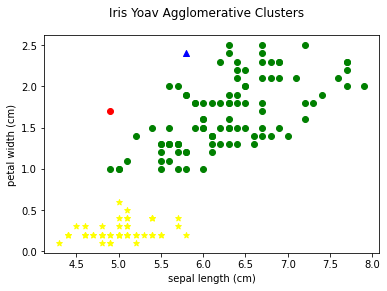

In [226]:
iris_labels = numpy.array(iris_labels)

fig = matplotlib.pyplot.figure()
fig.suptitle('Iris Yoav Agglomerative Clusters')
matplotlib.pyplot.xlabel(iris.feature_names[x1_feature])
matplotlib.pyplot.ylabel(iris.feature_names[x2_feature])

scatter_0 = matplotlib.pyplot.scatter(x1[iris_labels==0], x2[iris_labels==0],
                                      c="red", marker="o", label=iris.target_names[0])
scatter_1 = matplotlib.pyplot.scatter(x1[iris_labels==1], x2[iris_labels==1],
                                      c="blue", marker="^", label=iris.target_names[1])
scatter_2 = matplotlib.pyplot.scatter(x1[iris_labels==2], x2[iris_labels==2],
                                      c="yellow", marker="*", label=iris.target_names[2])
scatter_3 = matplotlib.pyplot.scatter(x1[iris_labels==3], x2[iris_labels==3],
                                      c="green", marker="o")

#matplotlib.pyplot.legend(handles=[scatter_0, scatter_1, scatter_2])

matplotlib.pyplot.show()

Performing as expected. I'd say that's a success.

# Standardizing DBSCAN Inputs

In [11]:
def standardized_dbscan_clusters(npoint_list, radius, min_neighbor):
    scaler = StandardScaler()
    point_list = scaler.fit_transform(npoint_list).tolist()
    cluster_counter = 2  # 0 means untested, 1 means noise, the rest are clusters
    labels = [0 for x in range(len(point_list))]
    for i in range(len(point_list)):
        if labels[i] == 0:
            if len(points_in_radius(point_list, i, radius, [i])) >= min_neighbor:
                new_cluster = determine_cluster(point_list, i, radius)
                for idx in new_cluster:
                    labels[idx] = cluster_counter
                cluster_counter += 1
            else:
                labels[i] = 1
    return labels

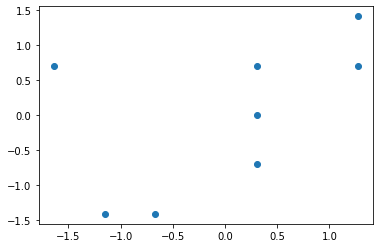

In [11]:
scaler = StandardScaler()
point_list = scaler.fit_transform(test_list).tolist()
matplotlib.pyplot.scatter([x[0] for x in point_list], [x[1] for x in point_list])

Cool. Let's see the effect in the 3d irises.

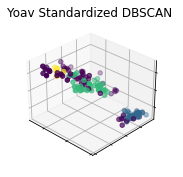

In [23]:
all_figure = matplotlib.pyplot.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

iris_labels = standardized_dbscan_clusters(iris.data.tolist(), 0.42, 3)
add_plot(all_figure, 1, "Yoav Standardized DBSCAN", iris_df, numpy.array(iris_labels))

The model performed poorer than the normal one. We still got 3 classes here, the top one is too small and there are a lot more points classified as noise. Although standardizing did not help much in this problem, simply because the different units did help differentiate between species, it could still be useful in other datasets and problems where units vary drastically.